## M2L: ConvNets and Computer Vision Tutorial (PART I)

### Supervised classification, overfitting and inductive biases in convnets, and how to improve models through self-supervision
### by Marco Buzzelli, Luigi Celona, Flavio Piccoli, and Simone Zini

* Exercise 1: Implement and train a ResNetSE-18 classifier using supervised learning; enable/disable batch norm updates to see the effect.
* Exercise 2: Inductive biases in convnets; comparison with MLP.
* Exercise 3: Overfitting and regularization using weight decay.
* Exercise 4: Enable self-supervised learning using data augmentation.

**Questions**: 
1. What happens with resnet's performance when batch norm statistics are not updated? How about MLP? Why is one affected less than the other?
2. What is resnet's train loss on permuted MNIST? How about the test accuracy? How is the MLP affected by the permutation?
3. What other types of regularization could you use to avoid overfitting?
4. In what applications do you expect the auxiliary self-supervised task to help more?

## Import JAX, Haiku, and other libraries

In [1]:
!pip install git+https://github.com/deepmind/dm-haiku &> /dev/null
!pip install -U tensorboard &> /dev/null
!pip install -q dm-tree &> /dev/null
!pip install git+https://github.com/deepmind/optax.git &> /dev/null

In [2]:
import os
import tree
import math
import time
import pickle
import warnings

# Dataset libraries
import tensorflow as tf
import tensorflow_datasets as tfds

import haiku as hk
import jax
import optax
import jax.numpy as jnp

import numpy as np

# Plotting library.
from matplotlib import pyplot as plt
from IPython import display

#@title Imports
from typing import Iterable, Mapping, Tuple, \
    Generator, Sequence, Optional, Union

# Don't forget to select GPU runtime environment in Runtime -> Change runtime type
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

warnings.filterwarnings('ignore')

# Define useful types
Batch = Mapping[np.ndarray, np.ndarray]
OptState = Tuple[optax.TraceState,
                 optax.ScaleByScheduleState,
                 optax.ScaleState]

Found GPU at: /device:GPU:0


## Download dataset to be used for training and testing
* MNIST images

* 70000 28x28 grayscale images in 10 classes: digits from 0 to 9

* train: 60000; test: 10000

In [3]:
# Dataset constants for MNIST dataset:
# it contains low-res natural images (28x28x1) belonging to 10 classes.
dataset_name = 'mnist'
class_mnist = [u'0', u'1', u'2', u'3', u'4', u'5', u'6', u'7', u'8', u'9']
train_split = 'train'
eval_split = 'test'
num_examples = {train_split: 60000,
                eval_split: 10000}
num_classes = 10

train_ds = tfds.load(dataset_name, split=train_split)
test_ds = tfds.load(dataset_name, split=eval_split)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


## Display the images
The gallery function below shows sample images from the data, together with their labels.

In [4]:
MAX_IMAGES = 10


def gallery(dataset, num_frames, title='Input images'):
    num_frames = min(num_frames, MAX_IMAGES)
    ff, axes = plt.subplots(1, num_frames,
                            figsize=(num_frames, 1),
                            subplot_kw={'xticks': [], 'yticks': []})
    i = 0
    sample = dataset.next()
    while sample and i < num_frames:
        image = sample['image']
        if image.shape[-1] == 3:
            axes[i].imshow(image)
        else:
            axes[i].imshow(image[:,:,0], cmap='gray')
        axes[i].set_title(class_mnist[sample['label']])
        plt.setp(axes[i].get_xticklabels(), visible=False)
        plt.setp(axes[i].get_yticklabels(), visible=False)
        sample = dataset.next()
        i += 1
    ff.subplots_adjust(wspace=0.1)
    plt.show()

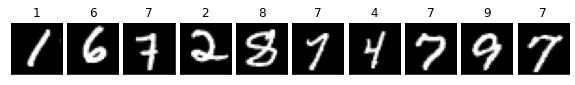

In [5]:
gallery(train_ds.shuffle(10).as_numpy_iterator(), num_examples[train_split])

## Prepare the data for training and testing
* We use tensorflow readers; JAX does not have support for input data reading and pre-processing
* for training, we use stochastic optimizers (e.g. SGD, Adam), so we need to sample at random mini-batches from the training dataset
* for testing, we iterate sequentially through the test set

### Excercise 2: Permute pixel values
In Exercise 2, we evaluate how a convnet generalizes with respect to the spatial permutation of pixel values ![](https://github.com/m2lschool/tutorials2021/blob/main/assets/vision_part1_pixel_permutation.jpg?raw=true).
* All images (both training and test images) are modified using the same permuted index list.

In [6]:
#@title 28x28 permutation list (for Exercise 3) { form-width: "40%" }
def get_permutation_mnist():
    p = tf.constant([273,  746,  197,  597,  519,  757,  113,  470,
                     321,  552,  585,  246,  229,  569,  773,    6,
                     379,  548,  148,  503,   27,  132,   82,  101,
                     260,   53,  635,  203,  439,  487,  162,  395,
                     311,  593,   33,  183,  215,  264,  699,  692,
                     560,  124,  126,  708,   41,  368,  484,  467,
                     267,  731,   17,   73,   14,  521,  240,  296,
                     43,   779,  629,  640,  268,  150,  586,   56,
                     756,  769,  382,  354,   95,  283,  775,  432,
                     178,  271,  118,  563,  445,  261,  518,  723,
                     725,  449,  595,  617,  607,  400,  697,   96,
                     656,  138,  343,  653,  175,  433,  681,  654,
                     574,  322,  754,  381,   12,  338,  182,  695,
                     556,  491,  512,  717,  224,  303,  496,  693,
                     140,  599,  332,  758,  465,   80,  501,  690,
                     422,  211,  331,  313,  583,  128,  776,  168,
                     463,  201,  334,  228,  643,  514,  106,  713,
                     507,  543,  703,  299,   74,  263,  710,  622,
                     486,  344,  210,  687,  537,  362,  688,  320,
                     91,   403,  778,  534,  674,  783,  284,  724,
                     549,  184,  605,   15,    8,  535,   85,  495,
                     774,  701,  416,  642,  553,  370,  571,  489,
                     388,  171,  761,  475,  397,  227,  753,  278,
                     155,  748,  745,  437,  414,  181,  759,  234,
                     143,  554,  762,   46,  476,  417,  716,  336,
                     117,   47,  602,  525,  718,  660,  760,  451,
                     142,  609,  405,  455,  315,  394,   36,  389,
                     719,  715,  386,  393,  446,  109,  658,  612,
                     685,  577,  641,  770,  510,  704,  275,  335,
                     259,  307,  435,  712,  326,  232,  237,  172,
                     675,   84,  670,  434,  485,   68,  677,  415,
                     492,  732,  366,  557,   22,  765,  722,  579,
                     288,  308,   48,  198,  481,  604,  139,  647,
                     115,  618,  243,  466,  107,  440,  152,  200,
                     230,   83,  755,   10,  144,  749,  528,  494,
                     199,  546,  282,  223,  346,  352,  421,  763,
                     424,  328,  290,   13,   62,  129,  156,  436,
                     252,  359,  538,   35,  459,  226,  657,  401,
                     191,  483,  187,  242,  680,  646,  473,    4,
                     581,  130,  666,  709,    7,  236,  450,  532,
                     667,   70,  410,  266,  189,  649,  257,  700,
                     500,  188,  634,   25,  517,  573,  104,  387,
                     673,  638,  540,  249,  610,  110,  480,  663,
                     9,    225,  339,  398,  131,  372,  628,  174,
                     488,   79,  766,  310,  468,  691,  425,  289,
                     616,  309,  570,  636,  768,  591,  464,  412,
                     120,  782,  652,  541,  100,  280,  721,  423,
                     430,  442,  506,  160,  502,  333,  615,  399,
                     57,   250,  384,   71,  103,  429,  411,   59,
                     529,  630,  444,  625,  179,  747,  218,  627,
                     408,  443,  305,  733,  509,  274,  682,  584,
                     358,  536,  739,  369,  221,  247,  676,  206,
                     1,    438,  265,  672,  287,   26,   39,  606,
                     479,  102,  291,   88,  205,   61,  127,  351,
                     477,  655,  355,   67,   37,  735,  458,  454,
                     737,  173,  231,  158,  555,  337,  644,  505,
                     233,  730,  431,  530,  580,  312,  720,  441,
                     550,  367,  513,   50,  371,   34,   45,  705,
                     153,  122,  209,   51,  216,  185,  611,  327,
                     603,  428,   42,  669,  601,  620,  771,  116,
                     293,  363,   81,   90,  474,   94,  302,   31,
                     317,  619,  471,   86,   64,   683,  20,  330,
                     472,  650,  714,  380,  196,  272,  736,  349,
                      75,  169,   28,  340,  163,  151,  582,  559,
                     376,   24,  539,  176,  207,  600,  767,  592,
                     726,  277,  511,   98,  498,  668,  298,  292,
                     523,  598,  742,  623,  426,  361,  121,  157,
                     146,  490,  780,  360,  679,   38,  222,  419,
                     192,  587,   30,   77,  702,  235,  318,  751,
                     2,    396,  542,  661,  499,   29,   69,  180,
                     621,  217,  588,   58,   60,  164,  772,  545,
                     452,  170,  752,  281,  478,  711,  648,  575,
                     213,  345,   19,  190,  527,  508,  149,  323,
                     624,  404,  420,  256,  413,  626,  134,  390,
                     614,  342,  565,  238,  241,  781,  590,  533,
                     659,  365,  561,  112,  248,  357,  566,  407,
                     253,  461,  594,  255,  406,  750,    3,  356,
                     141,   97,   92,  522,  734,  325,   54,  738,
                     456,  133,  374,   66,  729,  114,  214,  504,
                     383,  631,  347,  686,  578,  613,  239,  645,
                     764,  427,  651,  568,   87,  119,   63,   65,
                     202,  286,  409,  662,  551,   49,  251,  572,
                     632,    5,  524,  515,  608,  208,  329,   18,
                     516,  350,  295,  448,  385,  678,  258,  204,
                     276,  177,   72,  341,   16,  497,  316,  262,
                     544,  526,  707,  348,  254,  447,  520,  453,
                     270,  304,  558,  462,  418,  279,   99,  353,
                     314,  306,  564,  219,  167,  186,  297,  706,
                     0,     89,   11,  402,  531,   78,  728,  373,
                     562,  684,  194,  195,  294,  567,  698,  378,
                     589,   40,  220,  493,  460,   76,  105,  639,
                     324,  166,  740,   23,   52,  161,  319,  392,
                     135,  111,  391,  547,  145,  123,  744,  364,
                     147,  469,  125,  159,  664,   93,  727,  245,
                     696,  377,   21,  665,  694,   55,  269,  285,
                     671,  165,  193,  244,  457,  741,  375,  482,
                     576,  108,  743,  689,  300,   44,   32,  136,
                     596,  637,  137,  154,  633,  777,  301,  212])

    return p

### Self-supervised learning task: learn the rotation!
In exercise 4, we implement a self-supervised approach which consists in randomly rotating the images by multiples of 90 degrees (e.g. 0, 90, 180, or 270 degrees) and learning to recognize the rotation that has been applied. ![](https://github.com/m2lschool/tutorials2021/blob/main/assets/vision_part1_im_rotate.jpg?raw=true)

In [58]:
#@title Dataset loading and preprocessing { form-width: "40%" }
# We use tensorflow readers; JAX does not have support for input data reading
# and pre-processing.
def load(ds,
         is_training: bool,
         flag_permute: bool,
         flag_selfsup: bool,
         num_transf,
         batch_size: int) -> Generator[Batch, None, None]:
    """Loads the dataset as a generator of batches."""
    ds = ds.cache().repeat()

    if is_training:
        ds = ds.shuffle(10 * batch_size, seed=0)

    # Define the preprocessing for each train and test image
    def preprocess(example):
        image, label_transf = _preprocess_image(example['image'],
                                                is_training,
                                                flag_permute,
                                                flag_selfsup,
                                                num_transf)
        return {'image': image, 'label': example['label'],
                'label_transf': label_transf}

    # Apply the preprocessing function to all samples in a batch using `map`
    ds = ds.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # Get samples grouped in mini-batches to train using SGD
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)

    return tfds.as_numpy(ds)  # return numpy array


def _preprocess_image(image: tf.Tensor, is_training: bool,
                      flag_permute: bool, flag_selfsup: bool,
                      num_transf) -> tf.Tensor:
    """Returns processed and resized image."""
    # Images are stored as uint8; we convert to float for further processing.
    image = tf.cast(image, tf.float32)
    # Normalise pixel values between -1 and 1: original images are in [0, 255].
    # We normalise to [-1, 1] to have 0 mean and unit variance in the inputs,
    # as it makes the training more stable. Note that we do this normalisation
    # over the activations of all the layers in the network by using batch
    # normalisation layers.
    image = 2 * (image / 255.0) - 1.0

    # During training, we use data augmentation.
    # In this way, we are effectively increasing the size of the training
    # dataset, leading to improved generalisation.
    label_transf = []
    if is_training:

        # Data augmentation
        # - apply horizontal flip randomly
        # - random crop after padding
        # - apply optional data augmentation (permutation, rotation)
        image = tf.image.random_flip_left_right(image)
        # Pad images by reflecting the boundaries and randomly sample a
        # 32x32 patch.
        image = tf.pad(image, [[4, 4], [4, 4], [0, 0]], mode='REFLECT')
        image = tf.image.random_crop(image, size=(28, 28, 1))

    # Exercise 2: permuted MNIST; scramble the images using a fixed permutation
    if flag_permute:
        ################
        # YOUR CODE HERE  reshape image 2D -> 1D array using tf.reshape
        image = tf.reshape(image, 28*28*1)

        p = get_permutation_mnist()
        ################
        # YOUR CODE HERE  permute pixels according to permutation p using
        #                 tf.gather(..., axis=0). We have batches 
        image = tf.gather(params=image, indices=p)
        # YOUR CODE HERE  reshape to original shape
        image = tf.reshape(image, shape=(28,28,1))

    # Excercise 4: data augmentation as self-supervision signal:
    # for every image sample uniformly at random a transformation (rotation),
    # and apply it to the image while returning the id of the transformation
    if is_training and flag_selfsup and num_transf:
        ################
        # YOUR CODE HERE get a transformation label_transf = tf.random.uniform...
        label_transf = tf.random.uniform((num_transf, ))
        # YOUR CODE HERE apply transformation image = \
        #                tf.image.rot90(image, k=label_transf)
        image = tf.image.rot90(image, k=num_transf)
    
    return image, label_transf

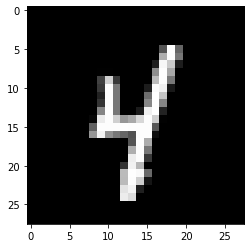

In [59]:
sample = train_ds.shuffle(1).as_numpy_iterator().next()
plt.imshow(sample['image'][:,:,0], cmap='gray')

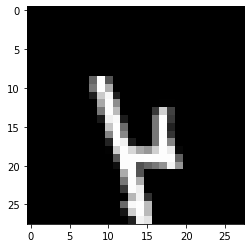

In [69]:
img, l = _preprocess_image(image=sample['image'], is_training=True,
                      flag_permute=False, flag_selfsup=True, num_transf=4) 
plt.imshow(img[:,:,0], cmap='gray')

## General setting; use the options below to switch between exercises.

In [70]:
MODEL = "resnet_v2"  #@param['resnet_v2','mlp']
FLAG_UPDATE_BN_STATS = True  #@param['True', 'False'] {type:"raw"}
FLAG_PERMUTE = False  #@param['True', 'False'] {type:"raw"}
FLAG_REGULARIZE = False  #@param['True', 'False'] {type:"raw"}
FLAG_SELFSUP = False  #@param['True', 'False'] {type:"raw"}

## Define the model
[Squeeze-and-Excitation (SE)](https://arxiv.org/pdf/1709.01507.pdf) blocks to our Resnet18 baseline

The Squeeze-and-Excitation blocks (figures from original paper [Squeeze-and-Excitation Networks](https://arxiv.org/pdf/1709.01507.pdf)) 
![SE block](https://github.com/eemlcommunity/PracticalSessions2020/blob/master/assets/SE.png?raw=true)
implement a simple form of *self-attention*. A self-attention module, in general, receives a number of inputs and produces the same number of outputs. The operations applied inside the block allow the inputs to interact with each other ("self") and recalibrate each other, based on which are deemed more important for that particular sample. 

The goal of SE block is to apply self-attention at the level of feature channels to allow them to recalibrate using more global information (as opposed to the local information available to conv units).    

The Squeeze-and-excitation block has two steps:
* *squeeze*: Given an input feature block, extract a global descriptor, one value per channel; a simple global descriptor can be obtained through spatial average global pooling
* *excite*: Based on the global descriptor, learn a weight vector (using an MLP) to be applied as a gating mechanism on the original features. The output non-linearity of the block is a `sigmoid` (and not e.g. a softmax) to allow multiple feature channels to be emphasised. These weights are then applied (through broadcasting) over the original features, emphasising the features that are more important for those inputs.


In [71]:
img.shape

TensorShape([28, 28, 1])

In [88]:
jnp.mean(img.numpy(), axis=[1, 2]).shape

(28,)

In [74]:
jax.nn.relu

In [89]:
class SEBlock(hk.Module):
    """Squeeze and Excitation block."""
    def __init__(self, channels: Sequence[int],
                 name: Optional[str] = None):
        super().__init__(name=name)
        check_length(2, channels, "channels")
        self.fc1 = hk.Linear(channels[0])
        self.fc2 = hk.Linear(channels[1])

    def __call__(self, inputs):
        ################
        # YOUR CODE HERE

        # Apply the squeeze step using spatial average global pooling
        # YOUR CODE HERE out = jnp.mean(...
        out = jnp.mean(inputs, axis=[1, 2])
        
        # Excite step: linear layer, ReLU, linear layer, sigmoid
        # YOUR CODE HERE out = ...
        out = jax.nn.relu(self.fc1(out))
        out = jax.nn.sigmoid(self.fc2(out))
        
        # Scale the input features with the obtained self-attention weights
        # YOUR CODE HERE out = jnp.expand_dims(out, axis=(1, 2))
        out = jnp.expand_dims(out, axis=(1, 2))
        # YOUR CODE HERE out = ...
        out = inputs * out
        return out

### SE-Resnet module

To apply the SE block to a Resnet architecture, we simply insert the SE block within each resnet block before the element-wise addition between the shortcut and the residual connections

![alt text](https://github.com/eemlcommunity/PracticalSessions2020/blob/master/assets/SEresnet.png?raw=true)

### Create a resnet block

In a typical sequential model (no branching), the network as a whole is optimised to find the mapping between inputs and correct labels. In residual networks, each layer can learn an additive residual representation wrt to the representation already computed up to the previous layer, making the optimisation easier.

As opposed to [resnet-v1](https://arxiv.org/pdf/1512.03385.pdf) blocks (left), [resnet-v2](https://arxiv.org/pdf/1603.05027.pdf) blocks (right) use pre-activation modules, i.e. the batch normalisation (`BN`) and relu (`ReLU`) nonlinearity are applied within the resnet block, before the convolutional layer (`weight`). This allows the model to learn identity mappings over the shortcuts throughout the network, improving further the backpropagation of gradients.   

<img src="https://github.com/eemlcommunity/PracticalSessions2020/blob/master/assets/v1v2.png?raw=true" alt="resnet blocks" style="width: 80px;"/>

Figure from original [resnet-v2 paper](https://arxiv.org/pdf/1603.05027.pdf).

*Bottleneck blocks*: To reduce the number of parameters and memory footprint without sacrificing expressivity, bottleneck blocks can be applied. Instead of using 2 conv layers (`weight` in the figure above) with 3x3 filters, empirically it is shown that projecting in a lower dimensional space (using 1x1 conv layers), applying 3x3 convolutions, and then reprojecting back into the original dimension space, does not affect accuracy.    

*1x1 conv shortcuts*: when the input and the output of a resnet block have different numbers of channels, 1x1 convolutional layers are used on the shortcut to project the representation to the desired output feature dimension.

## Resnet block with self-attention (coding exercise)

In [ ]:
def check_length(length, value, name):
    if len(value) != length:
        raise ValueError(f"`{name}` must be of length 4 not {len(value)}")


class BlockV2(hk.Module):
    """ResNet V2 block with optional bottleneck."""
    def __init__(self,
                 channels: int,
                 stride: Union[int, Sequence[int]],
                 use_projection: bool,
                 bn_config: Mapping[str, float],
                 bottleneck: bool,
                 name: Optional[str] = None):
        super().__init__(name=name)
        self.use_projection = use_projection

        # Define batch norm parameters: the batch_norm layer normalises the
        # inputs to have zero mean and unit variance. To not affect the
        # expressivity of the network, e.g. in cases where it would be better
        # for the activations to not be 0-centred or to have larger variance,
        # batch_norm can optionally learn a scale and an offset parameters.
        bn_config = dict(bn_config)
        bn_config.setdefault("create_scale", True)
        bn_config.setdefault("create_offset", True)

        # See comment above about 1x1 conv shortcut
        if self.use_projection:
            self.proj_conv = hk.Conv2D(
                output_channels=channels,
                kernel_shape=1,
                stride=stride,
                with_bias=False,
                padding="SAME",
                name="shortcut_conv")

        # If we use bottleneck blocks (see comment above), inside the resnet
        # block we first project the activations into a lower dimensional
        # space, which has number of channels divided by `channel_div`
        # compared to the desired number of channels in the output.
        channel_div = 4 if bottleneck else 1
        conv_0 = hk.Conv2D(
            output_channels=channels // channel_div,
            kernel_shape=1 if bottleneck else 3,
            stride=1,
            with_bias=False,
            padding="SAME",
            name="conv_0")

        bn_0 = hk.BatchNorm(name="batchnorm_0", **bn_config)
        # Then we apply the 3x3 conv layer
        conv_1 = hk.Conv2D(
            output_channels=channels // channel_div,
            kernel_shape=3,
            stride=stride,
            with_bias=False,
            padding="SAME",
            name="conv_1")

        bn_1 = hk.BatchNorm(name="batchnorm_1", **bn_config)
        layers = ((conv_0, bn_0), (conv_1, bn_1))

        # When using bottleneck, we have also a 3rd 1x1 convolutional layer
        # within the resnet block (see comment above about bottleneck blocks)
        if bottleneck:
            conv_2 = hk.Conv2D(
                output_channels=channels,
                kernel_shape=1,
                stride=1,
                with_bias=False,
                padding="SAME",
                name="conv_2")

            bn_2 = hk.BatchNorm(name="batchnorm_2", **bn_config)
            layers = layers + ((conv_2, bn_2),)

        self.layers = layers
        ################
        # YOUR CODE HERE

        # Define the self-attention block
        # YOUR CODE HERE self.se_block = ...

    def __call__(self, inputs, is_training, test_local_stats):
        x = shortcut = inputs
        for i, (conv_i, bn_i) in enumerate(self.layers):
            # Apply pre-activation: batch_norm + relu
            x = bn_i(x, is_training, test_local_stats)
            x = jax.nn.relu(x)
            # If using 1x1 conv projection on the shortcut,
            # apply proj_conv once
            if i == 0 and self.use_projection:
                shortcut = self.proj_conv(x)
            # Apply convolution
            x = conv_i(x)

        ################
        # YOUR CODE HERE

        # Apply the SE block before the element-wise addition between
        # the shortcut and the residual
        # YOUR CODE HERE x = ...

        return x + shortcut

In [ ]:
#@title Stack resnet blocks { form-width: "40%" }
class BlockGroup(hk.Module):
    """Group of blocks for ResNet implementation."""

    def __init__(
        self,
        channels: int,
        num_blocks: int,
        stride: Union[int, Sequence[int]],
        bn_config: Mapping[str, float],
        bottleneck: bool,
        use_projection: bool,
        name: Optional[str] = None):
        super().__init__(name=name)

        self.blocks = []
        for i in range(num_blocks):
            self.blocks.append(
                BlockV2(channels=channels,
                        stride=(1 if i else stride),
                        use_projection=(i == 0 and use_projection),
                        bottleneck=bottleneck,
                        bn_config=bn_config,
                        name="block_%d" % (i)))

    def __call__(self, inputs, is_training, test_local_stats):
        out = inputs
        for block in self.blocks:
            out = block(out, is_training, test_local_stats)
        return out

In [ ]:
#@title Define a generic resnet architecture { form-width: "40%" }
# Note: This class is generic, it can be used to instantiate any Resnet
# model, e.g. Resnet-50, Resnet-101, etc. by substituting the correct block
# parameters
class ResNet(hk.Module):
    """ResNet model."""

    def __init__(
        self,
        blocks_per_group: Sequence[int],
        num_classes: int,
        num_transf: str,
        bn_config: Optional[Mapping[str, float]] = None,
        bottleneck: bool = True,
        channels_per_group: Sequence[int] = (256, 512, 1024, 2048),
        use_projection: Sequence[bool] = (True, True, True, True),
        name: Optional[str] = None,
    ):
        """Constructs a ResNet model.
        Args:
            blocks_per_group: A sequence of length 4 that indicates the number
                of blocks created in each group.
            num_classes: The number of classes to classify the inputs into.
            bn_config: A dictionary of two elements, `decay_rate` and `eps` to
                be passed on to the `BatchNorm` layers. By default the
                `decay_rate` is `0.9` and `eps` is `1e-5`.
            bottleneck: Whether the block should bottleneck or not. Defaults
                to True.
            channels_per_group: A sequence of length 4 that indicates the
                number of channels used for each block in each group.
            use_projection: A sequence of length 4 that indicates whether each
                residual block should use projection.
            name: Name of the module.
        """
        super().__init__(name=name)
        bn_config = dict(bn_config or {})
        bn_config.setdefault("decay_rate", 0.9)
        bn_config.setdefault("eps", 1e-5)
        bn_config.setdefault("create_scale", True)
        bn_config.setdefault("create_offset", True)

        # Number of blocks in each group for ResNet.
        check_length(4, blocks_per_group, "blocks_per_group")
        check_length(4, channels_per_group, "channels_per_group")

        # We first convolve the image with 7x7 filters, to be able to better
        # extract low-level features such as contours. Using conv with stride=2
        # halves the resolution of the input, reducing considerably the
        # computation cost, and increasing the receptive field.
        self.initial_conv = hk.Conv2D(
            output_channels=64,
            kernel_shape=7,
            stride=2,
            with_bias=False,
            padding="SAME",
            name="initial_conv")

        self.block_groups = []
        strides = (1, 2, 2, 2)
        for i in range(4):
            self.block_groups.append(
                BlockGroup(channels=channels_per_group[i],
                           num_blocks=blocks_per_group[i],
                           stride=strides[i],
                           bn_config=bn_config,
                           bottleneck=bottleneck,
                           use_projection=use_projection[i],
                           name="block_group_%d" % (i)))

        self.final_batchnorm = hk.BatchNorm(name="final_batchnorm", **bn_config)

        # Add output classifier
        self.logits = hk.Linear(num_classes, w_init=jnp.zeros, name="logits")

        # Add second head for transformation prediction
        self.logits_transf = None
        if num_transf:
            self.logits_transf = hk.Linear(num_transf, w_init=jnp.zeros,
                                           name="logits_transf")

    def __call__(self, inputs, is_training, test_local_stats=False):
        out = inputs
        out = self.initial_conv(out)
        # Reduce the spatial resolution of the activations by a factor of 2.
        # This increases the receptive field and reduces the computation cost.
        # Note that compared to a strided conv which has the same effects,
        # the pooling layers does not have trainable parameters.
        out = hk.max_pool(out,
                          window_shape=(1, 3, 3, 1),
                          strides=(1, 2, 2, 1),
                          padding="SAME")

        for block_group in self.block_groups:
            out = block_group(out, is_training, test_local_stats)

        out = self.final_batchnorm(out, is_training, test_local_stats)
        out = jax.nn.relu(out)

        # Pool over spatial dimensions to obtain the final vector embedding
        # of the image. Use jnp.mean and not hk.avg_pool, to make sure that the
        # network can be applied to inputs with any resolution without
        # modification of the model.
        out = jnp.mean(out, axis=[1, 2])

        logits_transf = None
        if self.logits_transf:
            logits_transf = self.logits_transf(out)

        return self.logits(out), logits_transf

In [ ]:
#@title Instantiate Resnet18 { form-width: "40%" }
class ResNet18(ResNet):
    """ResNet18."""

    def __init__(self,
                 num_classes: int, num_transf: str,
                 bn_config: Optional[Mapping[str, float]] = None,
                 name: Optional[str] = None):
        """Constructs a ResNet model.
        Args:
          num_classes: The number of classes to classify the inputs into.
          bn_config: A dictionary of two elements, `decay_rate` and `eps` to be
              passed on to the `BatchNorm` layers.
          name: Name of the module.
        """
        super().__init__(blocks_per_group=(2, 2, 2, 2),
                         num_classes=num_classes,
                         num_transf=num_transf,
                         bn_config=bn_config,
                         bottleneck=False,
                         channels_per_group=(64, 128, 256, 512),
                         use_projection=(False, True, True, True),
                         name=name)

## Define simple MLP baseline

In [ ]:
class MLP(hk.Module):
    def __init__(self, num_classes=10, num_transf=None):
        super().__init__()
        self.num_classes = num_classes
        self.num_transf = num_transf

    def __call__(self, inputs, is_training=True):
        batch_norm_args = {
            "is_training": is_training
        }
        bs = inputs.shape[0]
        inputs = jnp.reshape(inputs, [bs, -1])
        net = hk.Linear(1024)(inputs)
        net = jax.nn.relu(net)
        net = hk.BatchNorm(True,
                           True,
                           0.99,
                           eps=0.001,
                           name="bn_postnorm1")(inputs, **batch_norm_args)
        net = hk.Linear(1024)(net)
        net = jax.nn.relu(net)
        net = hk.BatchNorm(True,
                           True,
                           0.99,
                           eps=0.001,
                           name="bn_postnorm2")(net, **batch_norm_args)
        logits = hk.Linear(self.num_classes, name="logits")(net)
        logits_transf = None
        if self.num_transf:
            logits_transf = hk.Linear(self.num_transf,
                                      name="logits_transf")(net)
        return logits, logits_transf

## Hyper-parameters for training and optimiser

In [ ]:
INIT_RANDOM_SEED = 42  #@param
TRAIN_BATCH_SIZE = 128
TEST_BATCH_SIZE = 100

# Model parameters
# NUM_TRANSF can be None or 4 corresponding to 4 rotations (0, 90, 180, 270)
NUM_TRANSF = 4  #@param

# reduction ratio for SE blocks
REDUCTION_RATIO = 16  #@param

# Optimizer parameters
REGLOSS_WEIGHT_DECAY = 1e-4  #@param
OPTIMIZER_MOMENTUM = 0.9  #@param
OPTIMIZER_USE_NESTEROV = True  #@param

# Define number of training iterations and reporting intervals
TRAIN_ITERS = 100e2  #@param
SAVE_MODEL_EVERY = 100  #@param
REPORT_TEST_EVERY = 1000  #@param
TEST_ITERS = (num_examples[eval_split]) // TEST_BATCH_SIZE

### Instanciate either MLP baseline or convnet

In [ ]:
if MODEL == 'mlp':
    net_fn = lambda *args: MLP(num_classes=num_classes,
                               num_transf=NUM_TRANSF)(*args)
  
else:  # model is resnet_v2
    net_fn = lambda *args: ResNet18(num_classes, NUM_TRANSF)(*args)

# We use transform with state because we need to keep the state of the network,
# e.g. for batch norm statistics.
net = hk.transform_with_state(net_fn)

In [ ]:
# Get number of parameters in a scope by iterating through the
# trainable variables
def get_num_params(params: hk.Params) -> jnp.ndarray:
    total_parameters = 0
    for p in jax.tree_leaves(params):
        total_parameters += jnp.prod(jnp.asarray(p.shape))
    return total_parameters

In [ ]:
#@title Define learning rate schedule and optimizer { form-width: "40%" }
# We use learning rate annealing during training. We start with a larger
# learning rate `lr_init` which allows exploring faster the space of solutions
# and we reduce it by a factor of 10 `lr_factor` after a predefined number of
# steps. Smaller learning rate at the end of the training allows the model to
# explore a local neighbourhood and settle on a good local minimum.
def lr_schedule(step: jnp.ndarray) -> jnp.ndarray:
    """Define learning rate annealing schedule."""
    # After how many steps to apply the learning rate reduction
    boundaries = jnp.array((5000, 8000, 9500))  # after how many iterations
    # to reduce the learning rate
    # Every time we hit a predefined number of steps, we apply the reduction
    # of the learning rate by `lr_factor`
    lr_decay_exponent = jnp.sum(step >= boundaries)
    lr_init = 0.1  # initial value for learning rate
    lr_factor = 0.1  # reduce learning rate by this factor
    return lr_init * lr_factor**lr_decay_exponent


# Define the optimiser, we use SGD with nesterov momentum
def make_optimizer():
    """SGD and a custom lr schedule."""
    return optax.chain(optax.trace(decay=OPTIMIZER_MOMENTUM,
                                   nesterov=OPTIMIZER_USE_NESTEROV),
                       optax.scale_by_schedule(lr_schedule),
                       optax.scale(-1))

In [ ]:
#@title Define the loss function: cross-entropy for classification and weight decay for regularization { form-width: "40%" }
# Function to compute l2 loss - useful for regularisation
def l2_loss(params: Iterable[jnp.ndarray]) -> jnp.ndarray:
    return 0.5 * sum(jnp.sum(jnp.square(p)) for p in params)


# Function to compute softmax cross entropy for classification
def softmax_cross_entropy(
    *,
    logits: jnp.ndarray,
    labels: jnp.ndarray,
) -> jnp.ndarray:
    return -jnp.sum(labels * jax.nn.log_softmax(logits), axis=-1)


def loss_fn(
    params: hk.Params,
    state: hk.State,
    batch: Batch
) -> Tuple[jnp.ndarray, hk.State]:
    """Computes a regularized loss for the given batch."""
    # The third parameter would be an rng key if one is needed in running
    # the model, e.g. for dropout. If not needed, pass `None`.
    (logits, logits_selfsup), state = net.apply(params, state, None,
                                                batch['image'], True)

    # Estimate accuracy for the current batch
    predicted_label = jnp.argmax(logits, axis=-1)
    correct = jnp.sum(jnp.equal(predicted_label, batch['label']))
    acc = correct.astype(jnp.float32) / TRAIN_BATCH_SIZE

    # The labels are given as class indices; convert to one_hot representation
    labels = jax.nn.one_hot(batch['label'], num_classes)
    # Compute classification loss
    loss = jnp.mean(softmax_cross_entropy(logits=logits, labels=labels))

    # Exercise 3 - Add regularization
    if FLAG_REGULARIZE:
        ################
        # YOUR CODE HERE

        # Get all the trainable parameters of the model, except batch_norm
        # parameters to apply weight decay regularisation , i.e. we penalise
        # weights with large magnitude
        # YOUR CODE HERE l2_params = ...
        l2_params = [p for ((mod_name, _), p) in tree.flatten_with_path(params)
                     if 'batchnorm' not in mod_name]
        # We apply a weighting factor to the regularisation loss, so that it
        # does not dominate the total loss
        # YOUR CODE HERE reg_loss = REGLOSS_WEIGHT_DECAY * ...
        # YOUR CODE HERE loss += ...
        
    # Exercise 4 - Add auxiliary loss for self-supervised learning
    if FLAG_SELFSUP:
        ################
        # YOUR CODE HERE labels_selfsup = jax.nn.one_hot(batch['label_transf'], ...
        # YOUR CODE HERE loss += ...

    return loss, (state, acc)

In [ ]:
#@title Define the training step { form-width: "40%" }
@jax.jit
def train_step(
    params: hk.Params,
    state: hk.State,
    opt_state: OptState,
    batch: Batch,
) -> Tuple[hk.Params, hk.State, OptState, jnp.ndarray]:
    """Applies an update to parameters and returns new state."""
    (loss, aux_data), grads = (
      jax.value_and_grad(loss_fn, has_aux=True)(params, state, batch))

    state, acc = aux_data

    # Compute and apply updates via our optimizer.
    updates, opt_state = make_optimizer().update(grads, opt_state)
    params = optax.apply_updates(params, updates)

    return params, state, opt_state, loss, acc

In [ ]:
#@title Define the evaluation { form-width: "40%" }
@jax.jit
def eval_batch(
    params: hk.Params,
    state: hk.State,
    batch: Batch,
) -> jnp.ndarray:
    """Evaluates a batch."""
    # The third parameter would be an rng key if one is needed in running
    # the model, e.g. for dropout. If not needed, pass `None`.
    (logits, _), state = net.apply(params, state, None, batch['image'], False)
    predicted_label = jnp.argmax(logits, axis=-1)
    correct = jnp.sum(jnp.equal(predicted_label, batch['label']))
    return correct.astype(jnp.float32)


def evaluate(
    params: hk.Params,
    state: hk.State,
) -> jnp.ndarray:
    """Evaluates the model at the given params/state."""
    correct = jnp.array(0)
    total = 0
    test_dataset = load(test_ds, is_training=False, batch_size=TEST_BATCH_SIZE,
                        flag_permute=FLAG_PERMUTE, flag_selfsup=False,
                        num_transf=None)
    test_dataset = iter(test_dataset)
    for eval_iter in range(TEST_ITERS):
        correct += eval_batch(params, state, next(test_dataset))
        total += TEST_BATCH_SIZE

    return correct.item() / total

In [ ]:
#@title Initialise the model and the optimiser { form-width: "40%" }
def make_initial_state(
    rng: jnp.ndarray,
    batch: Batch,
) -> Tuple[hk.Params, hk.State, OptState]:
    """Computes the initial network state."""
    params, state = net.init(rng, batch['image'], True)
    opt_state = make_optimizer().init(params)
    return params, state, opt_state

## Training the model

In [ ]:
#@title Show training statistics using Tensorboard { form-width: "40%" }
import datetime
exp_dir = "exp_" + MODEL + ("", "_regularize")[FLAG_REGULARIZE] + \
    ("", "_permutepixels")[FLAG_PERMUTE] + ("", "_selfsup")[FLAG_SELFSUP] + \
    ("", "_updatebn")[FLAG_UPDATE_BN_STATS] + "/"

summary_writer = tf.summary.create_file_writer(
  exp_dir + "log/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [ ]:
# Launch the viewer
%load_ext tensorboard
%tensorboard --logdir {"."}

In [ ]:
# Get training dataset
train_dataset = load(train_ds, is_training=True, batch_size=TRAIN_BATCH_SIZE,
                     flag_permute=FLAG_PERMUTE, flag_selfsup=FLAG_SELFSUP,
                     num_transf=NUM_TRANSF)
train_dataset = iter(train_dataset)

In [ ]:
rng = jax.random.PRNGKey(INIT_RANDOM_SEED)

# Initialization requires an example input to calculate shapes of parameters.
batch = next(train_dataset)
params, state, opt_state = make_initial_state(rng, batch)

In [ ]:
# Get number of parameters in the model.
print("Total number of parameters of models")
print(get_num_params(params))

In [ ]:
for step_num in range(int(TRAIN_ITERS)):
    # Take a training step.
    batch = next(train_dataset)
    params, state, opt_state, train_loss, train_acc = \
    train_step(params, state, opt_state, batch)

    # We run evaluation during training to see the progress.
    if REPORT_TEST_EVERY > 0 and step_num % REPORT_TEST_EVERY == 0:
        eval_acc = evaluate(params, state)

    # Save model at fixed intervals.
    if step_num % SAVE_MODEL_EVERY == 0:
        with open(os.path.join(exp_dir, 'params.pkl'), 'wb') as handle:
            pickle.dump(params, handle, protocol=pickle.HIGHEST_PROTOCOL)

        with open(os.path.join(exp_dir, 'state.pkl'), 'wb') as handle:
            pickle.dump(state, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with summary_writer.as_default():
        tf.summary.scalar('train_loss', train_loss, step=step_num)
        tf.summary.scalar('train_acc', train_acc, step=step_num)
        tf.summary.scalar('test_acc', eval_acc, step=step_num)

# Once training has finished we run eval one more time to get final results.
eval_acc = evaluate(params, state)
print('[Eval acc FINAL]: %s' % (eval_acc))

# Save last model parameters
with open(os.path.join(exp_dir, 'params.pkl'), 'wb') as handle:
    pickle.dump(params, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(os.path.join(exp_dir, 'state.pkl'), 'wb') as handle:
    pickle.dump(state, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Restore the latest checkpoint and test

In [ ]:
!ls {exp_dir}

In [ ]:
# restoring the latest checkpoint in exp_dir
with open(os.path.join(exp_dir, 'params.pkl'), 'rb') as handle:
    params = pickle.load(handle)

with open(os.path.join(exp_dir, 'state.pkl'), 'rb') as handle:
    state = pickle.load(handle)

eval_acc = evaluate(params, state)
print('[Eval acc]: %s' % (eval_acc))